## Обучить AE собственной архитектуры на MNIST

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import gc
import torchvision

train_dataset = datasets.MNIST('/home/mors/Documents/Education/Current/Learning DS/NN/Reload_NN3-master', 
train = True, download=False,transform=torchvision.transforms.ToTensor())
test_dataset = datasets.MNIST('/home/mors/Documents/Education/Current/Learning DS/NN/Reload_NN3-master', 
train = False, download=False,transform=torchvision.transforms.ToTensor())

# Параметры
num_epoch = 8
batch_size = 256
input_d = 28*28
lr=0.001

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print('Using device:', device)

True
1
0
Using device: cuda


In [2]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_d, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(16, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_d),
            nn.ReLU()
        )

    def forward(self, inputs):
        zip = self.encoder(inputs)
        unzip = self.decoder(zip)

        return zip, unzip

In [3]:
# Инициируем модель
gc.collect()
torch.cuda.empty_cache()

modelAE = AutoEncoder()
modelAE = modelAE.to(device)
modelAE.train()

# Оптимизатор
optim = torch.optim.Adam(modelAE.parameters(), lr=lr)

# Функция потерь
criterio = nn.MSELoss()

In [4]:
# Обрабатываем
for epoch in range(num_epoch):
    data_loader = DataLoader(dataset=train_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             drop_last=True,
                             )

    for data, labels in data_loader:
        inputs = data.view(-1, 28*28).to(device)

        zip, unzip = modelAE(inputs)

        optim.zero_grad()
        loss = criterio(unzip, inputs)
        loss.backward()
        optim.step()

    print('[{}/{}] Loss:'.format(epoch+1, num_epoch), loss.item())


[1/8] Loss: 0.06131401285529137
[2/8] Loss: 0.046459298580884933
[3/8] Loss: 0.04394404590129852
[4/8] Loss: 0.04148127883672714
[5/8] Loss: 0.04202933982014656
[6/8] Loss: 0.041376058012247086
[7/8] Loss: 0.039710018783807755
[8/8] Loss: 0.040887173265218735


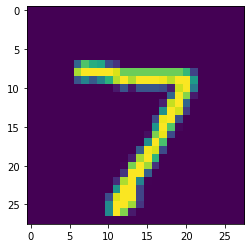

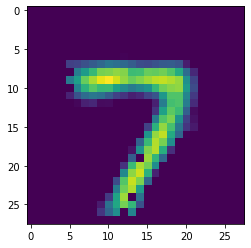

In [5]:
inputs = (test_dataset.data[0].view(-1, 28*28).float() / 255).to(device)
plt.imshow(test_dataset.data[0])
plt.show()
#---
code, outputs = modelAE(inputs)
plt.imshow(outputs.view(28, 28).cpu().detach().numpy())
plt.show()

## Обучить VAE собственной архитектуры на MNIST

In [15]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import gc
import torchvision
import torch.nn.functional as F

# Параметры
num_epochs = 8
batch_size = 256
lr=0.001

train_dataset = datasets.MNIST('/home/mors/Documents/Education/Current/Learning DS/NN/Reload_NN3-master', 
    train = True, download=False,transform=torchvision.transforms.ToTensor())
test_dataset = datasets.MNIST('/home/mors/Documents/Education/Current/Learning DS/NN/Reload_NN3-master', 
    train = False, download=False,transform=torchvision.transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

True
1
0
Using device: cuda


In [16]:
class VAE(nn.Module):
    def __init__(self, in_ch=1, hidden_ch=32*20*20, out_ch=256):
        super(VAE, self).__init__()
        
        self.enConv1 = nn.Conv2d(in_ch, 16, 5)
        self.enConv2 = nn.Conv2d(16, 32, 5)
        self.enFC1 = nn.Linear(hidden_ch, out_ch)
        self.enFC2 = nn.Linear(hidden_ch, out_ch)
        
        self.deFC1 = nn.Linear(out_ch, hidden_ch)
        self.deConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.deConv2 = nn.ConvTranspose2d(16, in_ch, 5)
        
    def encoder(self, x):
        
        x = nn.ReLU()(self.enConv1(x))
        x = nn.ReLU()(self.enConv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.enFC1(x)
        logVar = self.enFC2(x)
        return mu, logVar
    
    def reparameterize(self, mu, logVar):
        std = torch.exp(logVar /2)
        eps = torch.rand_like(std)
        
        return mu + eps * std
        
        
    def decoder(self, z):
        x = nn.ReLU()(self.deFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = nn.ReLU()(self.deConv1(x))
        x = torch.sigmoid(self.deConv2(x))
        return x
    
    def forward(self, x):
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar
        

In [17]:
# Инициируем модель
modelVAE = VAE().to(device)
modelVAE.train()

# Оптимизатор
optim = torch.optim.Adam(modelVAE.parameters(), lr=lr)

In [19]:
# Тренируем

gc.collect()
torch.cuda.empty_cache()

for epoch in range(num_epochs):
    for step, batch in enumerate(train_loader):
        data, _ = batch
        data = data.view(-1, 1,  28, 28).float().to(device)
        out, mu, logVar = modelVAE(data)
        
        kl = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, data, size_average=False) + kl
        
        optim.zero_grad()
        loss.backward()
        optim.step()
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), loss.item())

[1/8] Loss: 8401.5400390625
[2/8] Loss: 8186.921875
[3/8] Loss: 7426.11376953125
[4/8] Loss: 7828.63525390625
[5/8] Loss: 7612.18505859375
[6/8] Loss: 7480.2646484375
[7/8] Loss: 7117.3544921875
[8/8] Loss: 7123.1318359375


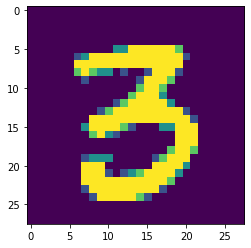

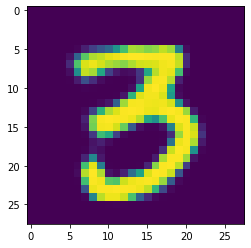

In [20]:
img = (test_dataset.data[5555].view(-1, 1,  28, 28).float() / 255).to(device)
plt.imshow(test_dataset.data[5555])
plt.show()
#---
out, mu, logVAR = modelVAE(img)
plt.imshow(out.view(28, 28).cpu().detach().numpy())
plt.show()